In [1]:
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf

In [2]:
import keras
from keras import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input

Using TensorFlow backend.


In [3]:
import stellargraph as sg

In [4]:
import pandas as pd

In [5]:
dataset = sg.datasets.METR_LA()

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: METR_LA is experimental: tests and documentation missing (see: https://github.com/stellargraph/stellargraph/issues/1303). It may be difficult to use and may have major changes at any time.
  """Entry point for launching an IPython kernel.


In [6]:
speed_data, sensor_dist_adj = dataset.load()
speed_data = speed_data.T
num_nodes = speed_data.shape[1]
time_len = speed_data.shape[0]
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


In [7]:
speed_data.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,...,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,...,42.708333,69.666667,64.388889,57.972222,66.708333,57.277778,64.986111,58.902778,69.285714,58.888889


In [8]:
def train_test_split(data, train_portion):
    time_len = data.shape[0]
    train_size = int(time_len * train_portion)
    train_data = np.array(data[:train_size])
    test_data = np.array(data[train_size:])
    return train_data, test_data

In [9]:
train_rate = 0.8

In [10]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (1612, 207)
Test data:  (404, 207)


In [11]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [12]:
train_scaled, test_scaled = scale_data(train_data, test_data)

In [13]:
seq_len = 10
pre_len = 12

In [14]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(len(train_data) - int(seq_len + pre_len - 1)):
        a = train_data[
            i : i + seq_len + pre_len,
        ]
        trainX.append(a[:seq_len])
        trainY.append(a[-1])

    for i in range(len(test_data) - int(seq_len + pre_len - 1)):
        b = test_data[
            i : i + seq_len + pre_len,
        ]
        testX.append(
            b[:seq_len,]
        )
        testY.append(b[-1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [15]:

trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 10, 207)
(1591, 207)
(383, 10, 207)
(383, 207)


In [16]:
from stellargraph.layer import GCN_LSTM

In [17]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[2, 2],
     
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200],
    lstm_activations=["tanh"],
)

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


In [18]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [19]:
keras.__version__

'2.2.5'

In [20]:
model = tf.keras.Model(inputs=x_input, outputs=x_output)

In [21]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [35]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 207, 10)]         0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 207, 10, 1)]      0         
_________________________________________________________________
reshape (Reshape)            (None, 207, 10)           0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 2)            43076     
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 2)            43060     
_________________________________________________________________
reshape_1 (Reshape)          (None, 207, 2, 1)         0         
_________________________________________________________________
permute (Permute)            (None, 2, 207, 1)        

In [23]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

W0814 08:31:33.306463 139879142262528 functional.py:587] Model was constructed with shape (None, 207, 10) for input Tensor("input_1:0", shape=(None, 207, 10), dtype=float32), but it was called on an input with incompatible shape (None, 10, 207).
W0814 08:31:34.761059 139879142262528 functional.py:587] Model was constructed with shape (None, 207, 10) for input Tensor("input_1:0", shape=(None, 207, 10), dtype=float32), but it was called on an input with incompatible shape (None, 10, 207).
W0814 08:31:37.129834 139879142262528 functional.py:587] Model was constructed with shape (None, 207, 10) for input Tensor("input_1:0", shape=(None, 207, 10), dtype=float32), but it was called on an input with incompatible shape (None, 10, 207).


In [24]:

print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.058908119797706604 
Test loss: 0.0


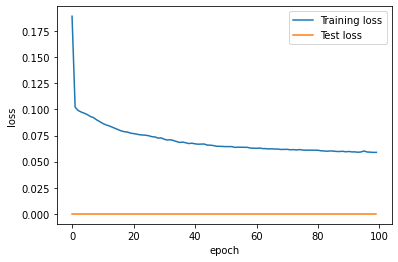

In [25]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [26]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

W0814 08:31:49.758388 139879142262528 functional.py:587] Model was constructed with shape (None, 207, 10) for input Tensor("input_1:0", shape=(None, 207, 10), dtype=float32), but it was called on an input with incompatible shape (None, 10, 207).


In [27]:

## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

In [28]:
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX).transpose(1, 0, 2)[
    -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [29]:

## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 5.033425628707047
Total (ave) MAE for naive prediction: 5.877064444860809
Total (ave) MASE for per-segment NN/naive MAE: 0.8662493937462306
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


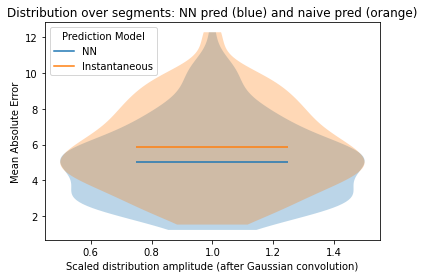

In [30]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

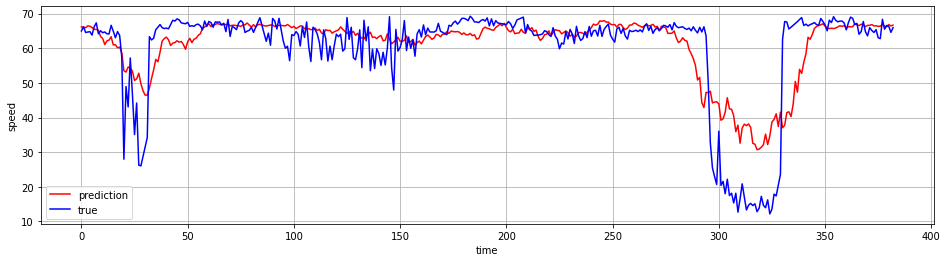

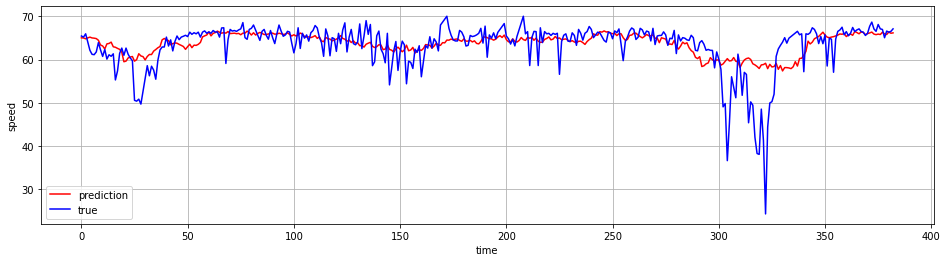

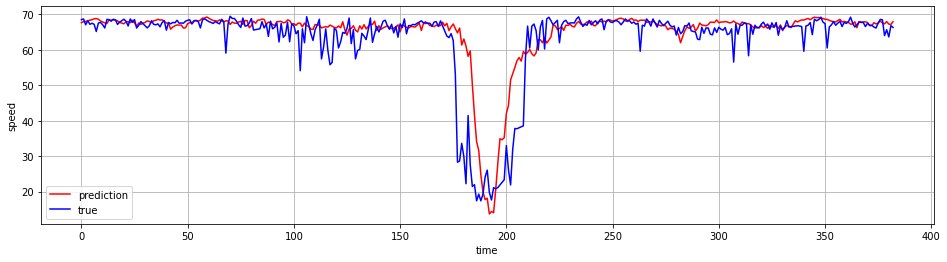

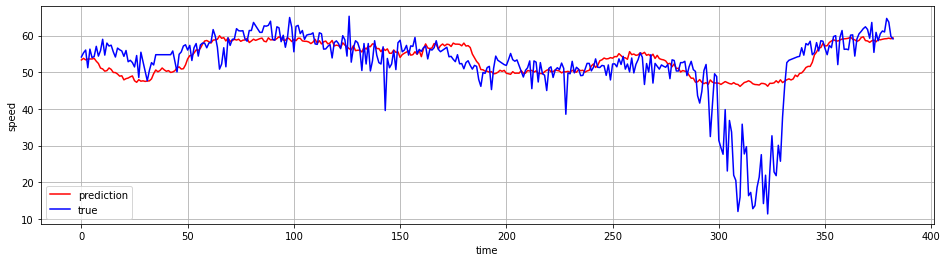

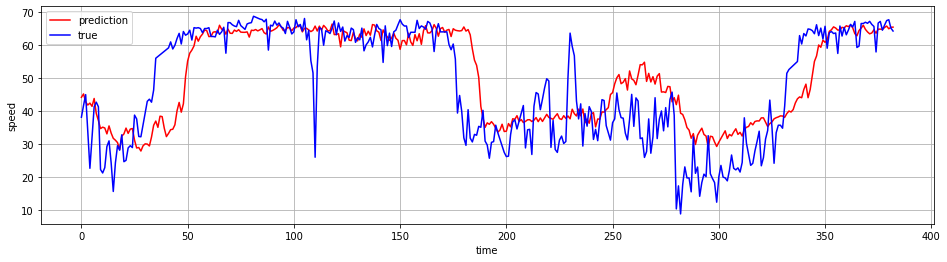

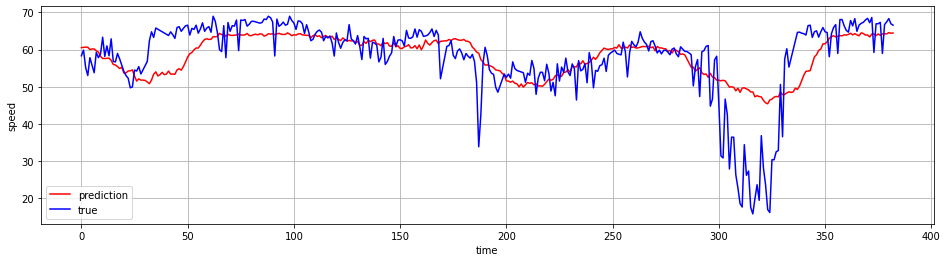

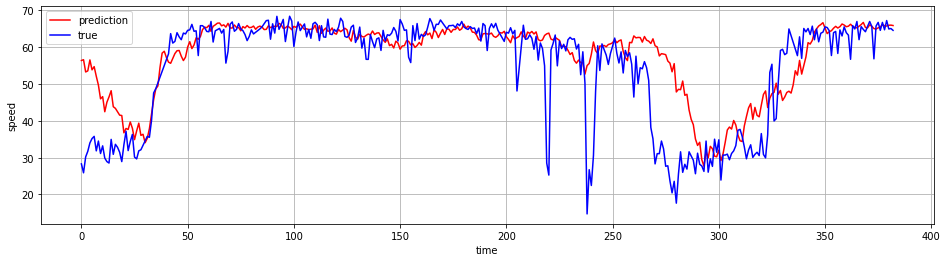

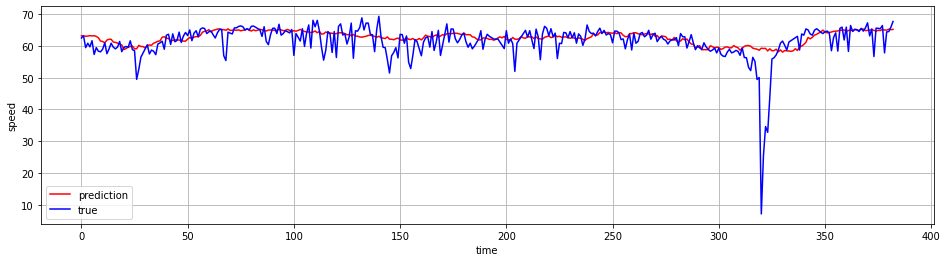

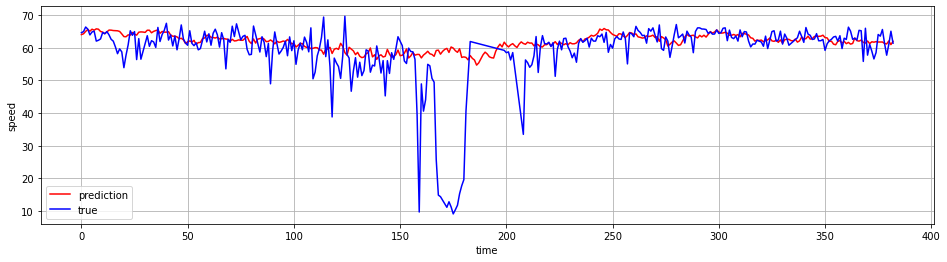

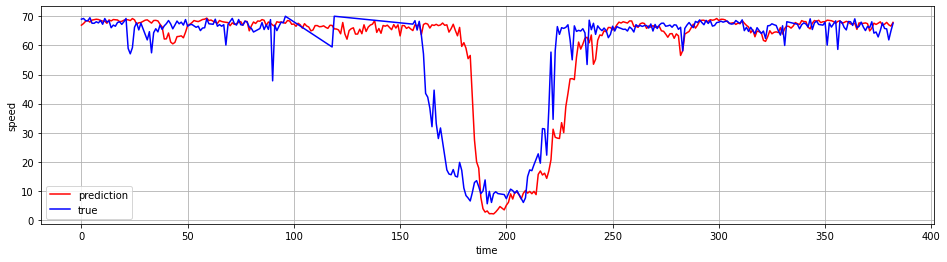

In [34]:
for i in range(10):
    ##all test result visualization
    fig1 = plt.figure(figsize=(16, 4))
    #    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_rescpred[:, i]
    a_true = test_rescref[:, i]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("time")
    plt.ylabel("speed")
    plt.legend(loc="best", fontsize=10)
    plt.grid()
    plt.show()